In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
words = pd.read_csv("https://raw.githubusercontent.com/karpathy/makemore/master/names.txt").values
words = words.reshape(1,-1)[0]
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32032
15
['olivia' 'ava' 'isabella' 'sophia' 'charlotte' 'mia' 'amelia' 'harper']


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [15]:
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train,  y_train  = build_dataset(words[:n1])     # 80%
X_val, y_val = build_dataset(words[n1:n2])   # 10%
X_test,  y_test  = build_dataset(words[n2:])   

torch.Size([182436, 8]) torch.Size([182436])
torch.Size([22844, 8]) torch.Size([22844])
torch.Size([22861, 8]) torch.Size([22861])


In [18]:
X_train[:20]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  7],
        [ 0,  0,  0,  0,  0,  0,  7,  5],
        [ 0,  0,  0,  0,  0,  7,  5,  4],
        [ 0,  0,  0,  0,  7,  5,  4,  5],
        [ 0,  0,  0,  7,  5,  4,  5, 15],
        [ 0,  0,  7,  5,  4,  5, 15, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  3],
        [ 0,  0,  0,  0,  0,  0,  3,  1],
        [ 0,  0,  0,  0,  0,  3,  1, 13],
        [ 0,  0,  0,  0,  3,  1, 13,  1],
        [ 0,  0,  0,  3,  1, 13,  1, 18],
        [ 0,  0,  3,  1, 13,  1, 18,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 13],
        [ 0,  0,  0,  0,  0,  0, 13, 21],
        [ 0,  0,  0,  0,  0, 13, 21,  8],
        [ 0,  0,  0,  0, 13, 21,  8,  1],
        [ 0,  0,  0, 13, 21,  8,  1, 13]])

In [16]:
for x,y in zip(X_train[:20], y_train[:20]):
    print("".join(itos[ix.item()] for ix in x),"-->",itos[y.item()])

........ --> g
.......g --> e
......ge --> d
.....ged --> e
....gede --> o
...gedeo --> n
..gedeon --> .
........ --> c
.......c --> a
......ca --> m
.....cam --> a
....cama --> r
...camar --> a
..camara --> .
........ --> m
.......m --> u
......mu --> h
.....muh --> a
....muha --> m
...muham --> m


In [200]:


# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
# ------------------------------------------------------------------------------------

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
# ------------------------------------------------------------------------------------

class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
# ------------------------------------------------------------------------------------

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n  
  
  def __call__(self, x):
    B,T,C = x.shape
    x = x.view(B, T//self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze()
    self.out = x
    return self.out
  
  def parameters(self):
    return []
  

class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [222]:

vocab_size = 27

n_embd = 24
n_hidden = 128

n_groups = 2

torch.manual_seed(42)

model = Sequential([
  Embedding(27, n_embd),
  FlattenConsecutive(n_groups), Linear(n_embd * n_groups, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_groups), Linear(n_hidden * n_groups, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(n_groups), Linear(n_hidden * n_groups, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in model.parameters():
  p.requires_grad = True

76963


In [225]:
layers = model.layers
print("Original -->", str(Xb.shape)[10:])
test = Xb
for layer in layers:
    print(layer.__class__.__name__,"-->", str(layer(test).shape)[10:])
    test = layer(test)


Original --> ([64, 8])
Embedding --> ([64, 8, 24])
FlattenConsecutive --> ([64, 4, 48])
Linear --> ([64, 4, 128])
BatchNorm1d --> ([64, 4, 128])
Tanh --> ([64, 4, 128])
FlattenConsecutive --> ([64, 2, 256])
Linear --> ([64, 2, 128])
BatchNorm1d --> ([64, 2, 128])
Tanh --> ([64, 2, 128])
FlattenConsecutive --> ([64, 256])
Linear --> ([64, 128])
BatchNorm1d --> ([64, 128])
Tanh --> ([64, 128])
Linear --> ([64, 27])


In [224]:
# same optimization as last time
max_steps = 50000
batch_size = 64
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], y_train[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1# step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization



      0/  50000: 3.2993
  10000/  50000: 2.1056
  10000/  50000: 2.1056
  20000/  50000: 1.8508
  20000/  50000: 1.8508
  30000/  50000: 1.7808
  30000/  50000: 1.7808
  40000/  50000: 1.7976
  40000/  50000: 1.7976


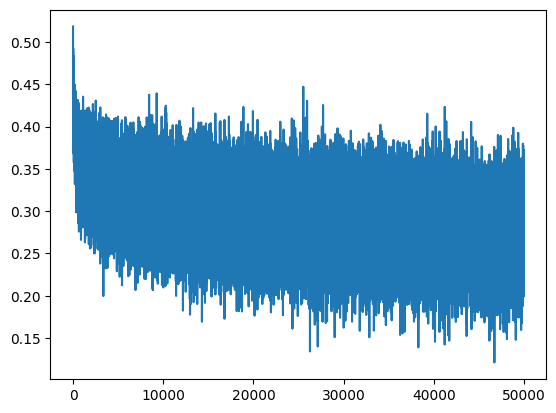

In [226]:
plt.plot(lossi)

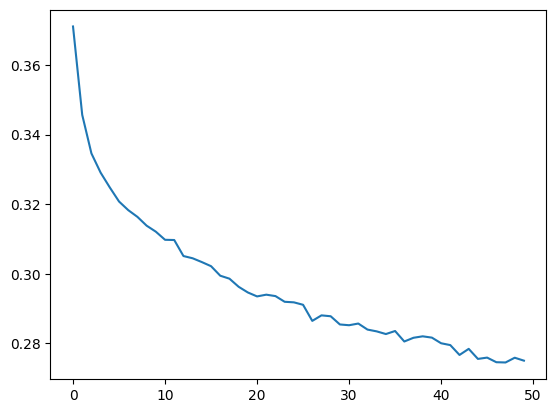

In [227]:

plt.plot(torch.as_tensor(lossi).view(-1,1000).mean(1))

In [228]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [229]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (X_train, y_train),
    'val': (X_val, y_val),
    'test': (X_test, y_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8772616386413574
val 2.0477468967437744


original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
context: 3 -> 8 (22K params): train 1.918, val 2.014

3 layers:
train 1.9781228303909302
val 2.0691566467285156

groupping by 2:
train 1.9538010358810425
val 2.0587151050567627

n_hidden=200:
train 1.8886357545852661
val 2.052396059036255

fixed batch norm layer:
train 1.8652535676956177
val 2.0483429431915283

n_emb = 24, n_hidden = 128
train 1.8772616386413574
val 2.0477468967437744

In [232]:
# sample from the model
torch.manual_seed(42)
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

anuelanvi.
syna.
idus.
xemus.
sasila.
leslote.
jolina.
sepper.
nasia.
kensin.
charony.
godder.
ranyah.
jaydevi.
indi.
zaylei.
tareth.
jaimar.
tal.
jenaya.


In [175]:
torch.manual_seed(42)
torch.rand(3,4,2).shape

torch.Size([3, 4, 2])

In [191]:
torch.manual_seed(42)
torch.rand(3,4,2).sum(0, keepdim=True).shape

torch.Size([1, 4, 2])

In [179]:
torch.rand(3,4).sum(0, keepdim=True).shape

torch.Size([1, 4])

In [199]:
torch.manual_seed(42)
a = torch.rand(3,4,2)
a.ndim

3